In [ ]:
# Explain the Goal of My Code
'''
1. Research Topic: Angular Momentum Alignment Between Stellar Remnants and Dark Matter Halos in Galaxy Mergers
2. Specific Question: How does the net angular momentum vector of the merged remnant halo compare to that of the
stellar remnant? Is it aligned? How does it evolve?
3. Goal: Plot the angular momentum alignment angle between the halo and stellar components over time, from pre-merger 
to post-merger.
'''

'\n1. Research Topic: Angular Momentum Alignment Between Stellar Remnants and Dark Matter Halos in Galaxy Mergers\n2. Specific Question: How does the net angular momentum vector of the merged remnant halo compare to that of the\nstellar remnant? Is it aligned? How does it evolve?\n3. Goal: Plot the angular momentum alignment angle between the halo and stellar components over time, from pre-merger \nto post-merger.\n'

In [ ]:
# 1st Plot Code Outline
'''
Step 0: Import necessary modules and functions (Read + CenterOfMass)

Step 1: Define functions to calculate angular momentum and separation 

Step 2: Define data file paths and initialize storage arrays

Step 3: Loop through each snapshot from the simulation
    a. Use the Read function to extract time
    b. Use the CenterOfMass class to get COM positions of MW and M31
    c. Calculate the separation between MW and M31

Step 4: Based on separation:
    a. If distance > 30 kpc:
        i. Treat MW and M31 separately
        ii. For each galaxy:
            - Extract halo and disk components using a radial cutoff (63 kpc for halo, 15 kpc for disk)
            - Compute net angular momentum vector for each
            - Rotate halo and disk particle vectors so that the stellar angular momentum aligns with the z-axis
            - Calculate the angle between L_halo and L_stellar using dot product's property
            - Store time and angle separately for MW and M31
    b. If distance ≤ 30 kpc:
        i. Combine halo and stellar components from MW and M31 using the same radial limits
        ii. Compute total angular momentum for each component
        iii. Rotate combined halo and disk particles so that total L_stellar aligns with the z-axis
        iv. Calculate the angle between combined L_halo and L_stellar using dot product's property
        v. Store time and angle for the merger remnant

Step 5: Plot the angle between halo and stellar angular momentum vectors vs. time
    a. Plot MW and M31 alignment before merger (separately)
    b. Plot the merger remnant alignment after the merging happened (combined MW and M31)
    c. Mark the merger point with a vertical dashed line
'''

"\nStep 0: Import necessary modules and functions (Read + CenterOfMass)\n\nStep 1: Define functions to calculate angular momentum and separation \n\nStep 2: Define data file paths and initialize storage arrays\n\nStep 3: Loop through each snapshot from the simulation\n    a. Use the Read function to extract time\n    b. Use the CenterOfMass class to get COM positions of MW and M31\n    c. Calculate the separation between MW and M31\n\nStep 3: Based on separation:\n    a. If distance > 30 kpc:\n        i. Treat MW and M31 separately\n        ii. For each galaxy:\n            - Extract halo and disk components\n            - Compute net angular momentum vector for each\n            - Calculate the angle between L_halo and L_stellar using dot product's property\n            - Store time and angle separately for MW and M31\n    b. If distance ≤ 30 kpc:\n        i. Combine halo and stellar components from MW and M31\n        ii. Compute total angular momentum for each component\n        iii

In [22]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import sys
import os

In [23]:
# Change path to homework3 where the ReadFile.py file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3'

# Add the directory to sys.path
sys.path.append(module_path)

# Import ReadFile
from ReadFile import Read

In [24]:
# Change path to homework4 where the class CenterOfMass file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework4'

# Add the directory to sys.path
sys.path.append(module_path)

# Import CenterOfMass class
from CenterOfMass import CenterOfMass

In [25]:
# Function to calculate angular momentum (with radial cutoff this time to prevent bias)
def angular_momentum(filename, ptype, r_max=None):
    """ Calculate the angle momentum of a specific particle type.

    Parameters
    ----------
    filename : `str`
        Filename of the text file containing the galaxy's particle data.
    ptype : `int`
        type of particle (halo, disk, or bulge)
    r_max : `float`
        Optional parameters. Maximum radius in kpc to include particles within this distance from COM.
        
    Returns
    -------------
    L : `np.array`
        Angular momentum vector (Lx, Ly, Lz) of the specified particle type relative to the galaxy's COM, computed as:

        L = sum(m_i * (r_i - r_COM) × (v_i - v_COM))

        where:
            - m_i is the mass of particle i
            - (r_i - r_COM) is the particle's position relative to the galaxy's COM
            - (v_i - v_COM) is the particle's velocity relative to the galaxy's COM
            - × is the vector cross product operation

    pos_rel.T : `np.array`
        - COM-shifted positions of the filtered particles (within `r_max`)
        - Transposed from (3, N) to (N, 3) shape so that each row is a position vector [x, y, z]
        - Use to rotate angular momentum into z-axis later on

    vel_rel.T : `np.array`
        - COM-shifted velocities of the filtered particles (within `r_max`) 
        - Transposed from (3, N) to (N, 3) shape so that each row is a velocity vector [vx, vy, vz]
        - Use to rotate angular momentum into z-axis later on
    """

    # Create a COM object for MW galaxy
    COM = CenterOfMass(filename, ptype)
    
    # Get COM position and velocity
    com_pos = COM.COM_P(0.1)
    com_vel = COM.COM_V(com_pos[0], com_pos[1], com_pos[2])

    # Remove units from com_pos and com_vel
    com_pos = com_pos.to(u.kpc).value
    com_vel = com_vel.to(u.km/u.s).value

    # Read particle data
    time, total, data = Read(filename)

    # Select particle type
    index = np.where(data['type'] == ptype)

    # Positions and velocities relative to COM
    pos_rel = np.array([data['x'][index] - com_pos[0],
                        data['y'][index] - com_pos[1],
                        data['z'][index] - com_pos[2]])
    vel_rel = np.array([data['vx'][index] - com_vel[0],
                        data['vy'][index] - com_vel[1],
                        data['vz'][index] - com_vel[2]])
    
    # Masses
    m = data['m'][index]

    # Calculate distances from COM
    r = np.sqrt(pos_rel[0]**2 + pos_rel[1]**2 + pos_rel[2]**2)

    # Apply radial cutoff if needed
    if r_max is not None:
        within = r < r_max
        pos_rel = pos_rel[:, within]
        vel_rel = vel_rel[:, within]
        m = m[within]

    # Calculate angular momentum L = sum(m * (r x v))
    # Initialize angular momentum vector
    L = np.zeros(3)

    # Loop through each particle to explicitly calculate angular momentum
    for i in range(len(m)):
        r_vec = pos_rel[:, i]      # Position vector of particle i relative to COM
        v_vec = vel_rel[:, i]      # Velocity vector of particle i relative to COM
        L += m[i] * np.cross(r_vec, v_vec)  # Summation of individual particle's angular momentum

    return L, pos_rel.T, vel_rel.T

In [26]:
# Define paths to MW and M31 snapshot data folders
path_MW = r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Research_Assignments\Research_Assignment_3\MW"
path_M31 = r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Research_Assignments\Research_Assignment_3\M31"

In [27]:
# Function to measure distance between MW and M31 centers
def separation_distance(snap):
    """Calculate the  separation between the MW and M31 galaxies using the positions of their disk 
    particles at a given snapshot.

    Parameters
    ----------
    snap : `int`
        Snapshot number (e.g., 000, 050, 100...)

    Returns
    -------
    dist : `float`
        The distance between MW and M31 (kpc).
    """

    # Extract snapshot
    fname_MW = f"{path_MW}\\MW_{snap:03}.txt"
    fname_M31 = f"{path_M31}\\M31_{snap:03}.txt"

    # Calculate the COM for each snapshot using the disk particles (type 2)
    COM_MW = CenterOfMass(fname_MW, 2)  
    COM_M31 = CenterOfMass(fname_M31, 2)

    # Get COM position for each snapshot
    r_MW = COM_MW.COM_P(0.1).value
    r_M31 = COM_M31.COM_P(0.1).value
    
    # Calculate the separation 
    dist = np.linalg.norm(r_MW - r_M31) 
    return dist

### Rodrigues' Rotation Formula

To rotate a vector **$\vec{v}$** around a unit axis **$\hat{n}$** by an angle **$\theta$**, the rotated vector **$\vec{v}_{\text{rot}}$** is given by:

$$
\vec{v}_{\text{rot}} = \vec{v} \cos\theta + (\hat{n} \times \vec{v}) \sin\theta + \hat{n} (\hat{n} \cdot \vec{v}) (1 - \cos\theta)
$$

But we can also use the **rotation matrix** **$R$** to performs this transformation by:
$$
\vec{v}_{\text{rot}} = R \cdot \vec{v}
$$

Where: 
$$
R = I + \sin\theta \cdot v_x + (1 - \cos\theta) \cdot v_x^2
$$

Where:

- **$I$** is the **identity matrix**
- **$v_x$** is the **skew-symmetric cross-product matrix** of the axis **$\hat{n}$**:

$$
v_x = 
\begin{bmatrix}
0 & -n_z & n_y \\
n_z & 0 & -n_x \\
-n_y & n_x & 0
\end{bmatrix}
$$

In [28]:
def RotateFrameFromL(posI, velI, L_vec):
    """Rotate position and velocity vectors so that angular momentum vector aligns with z-axis.
    
    Parameters
    ----------
    posI : `array of floats`
        3D array of positions (x, y, z)
    velI : `array of floats`
        3D array of velocities (vx, vy, vz)
    L_vec : `array of floats`
        Angular momentum vector (Lx, Ly, Lz)
    
    Returns
    -------
    pos: `array of floats`
        rotated 3D array of positions (x, y, z) such that disk is in the XY plane
    vel: `array of floats`
        rotated 3D array of velocities (vx, vy, vz) such that disk angular momentum vector is in the +z direction 
    """

    # Normalize the input angular momentum vector
    L_norm = L_vec / np.linalg.norm(L_vec)

    # Set up rotation matrix to map L_norm z unit vector (disk in xy-plane)
    # Target vector: z-axis
    z_axis = np.array([0, 0, 1])
    
    # Cross product between L and z
    v = np.cross(L_norm, z_axis)

    # Normalized the cross product
    # Correlate to sin(theta) in the formula
    s = np.linalg.norm(v)

    # Dot product between L and z
    # Correlate to cos(theta) in the formula
    c = np.dot(L_norm, z_axis)
    
    # Set up 3x3 identity matrix I
    I = np.eye(3)

    # Set up the skew-symmetric from v
    v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    
    # Calculate the rotational matrix 
    if s == 0: # if the axis align (cross product = 0)
        R = I
    else: # if not align
        R = I + v_x + (v_x @ v_x) * ((1 - c) / s**2) # apply Rodrigue's formula

    # Rotate positions and velocities
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T

    return pos, vel

In [29]:
# Empty arrays to store MW data
mw_times = []
mw_angles = []

# Empry arrays to store M31 data
m31_times = []
m31_angles = []

# Empty arrays to store merger data
merger_times = []
merger_angles = []

In [30]:
# Loop through snapshots
for snap in np.arange(0, 801, 50):
    # Extract snapshots from data files
    fname_MW = f"{path_MW}\\MW_{snap:03}.txt"
    fname_M31 = f"{path_M31}\\M31_{snap:03}.txt"

    # Read time
    time, _, _ = Read(fname_MW)
    t_gyr = time.to(u.Gyr).value # convert time to Gyr

    # Measure distance to determine if merger occured
    dist = separation_distance(snap)

    # Case 1: Before merger (assume distance > 30 kpc) — treat MW and M31 separately
    if dist > 30: 
        # MW angular momentum and filtered particle data for rotation
        L_halo_MW, pos_halo_MW, vel_halo_MW = angular_momentum(fname_MW, 1, 63)
        # MW angular momentum and filtered particle data for rotation
        L_star_MW, pos_star_MW, vel_star_MW = angular_momentum(fname_MW, 2, 15)

        # Rotate MW disk and halo particles to align with z-axis
        rot_pos_halo_MW, rot_vel_halo_MW = RotateFrameFromL(pos_halo_MW, vel_halo_MW, L_star_MW) # halo
        rot_pos_star_MW, rot_vel_star_MW = RotateFrameFromL(pos_star_MW, vel_star_MW, L_star_MW) # disk

        # cos theta = dot product / product of magnitude
        dot_mw = np.dot(L_halo_MW, L_star_MW)  # dot product
        mag_mw = np.linalg.norm(L_halo_MW) * np.linalg.norm(L_star_MW)  # product of magnitudes
        cos_theta_mw = dot_mw / mag_mw  # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent rounding errors (-1 <= cos(theta) <= 1)
        angle_mw = np.degrees(np.arccos(np.clip(cos_theta_mw, -1 , 1)))

        # Save MW times and alignment
        mw_times.append(t_gyr)
        mw_angles.append(angle_mw)

        # MW angular momentum and filtered particle data for rotation
        L_halo_M31, pos_halo_M31, vel_halo_M31 = angular_momentum(fname_M31, 1, 63)
        # MW angular momentum and filtered particle data for rotation
        L_star_M31, pos_star_M31, vel_star_M31 = angular_momentum(fname_M31, 2, 15)

        # Rotate MW disk and halo particles to align with z-axis
        rot_pos_halo_M31, rot_vel_halo_M31 = RotateFrameFromL(pos_halo_M31, vel_halo_M31, L_star_M31) # halo
        rot_pos_star_M31, rot_vel_star_M31 = RotateFrameFromL(pos_star_M31, vel_star_M31, L_star_M31) # disk

        # cos theta = dot product / magnitude
        dot_m31 = np.dot(L_halo_M31, L_star_M31)  # dot product
        mag_m31 = np.linalg.norm(L_halo_M31) * np.linalg.norm(L_star_M31)  # product of magnitudes
        cos_theta_m31 = dot_m31 / mag_m31  # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent round errors (-1 <= cos(theta) <= 1)
        angle_m31 = np.degrees(np.arccos(np.clip(cos_theta_m31, -1 , 1)))

        # Save M31 times and alignment
        m31_times.append(t_gyr)
        m31_angles.append(angle_m31)

    # Case 2: After merger (assume distance <= 30 kpc) — combine MW + M31 components
    else:
         # Compute halo angular momentum of MW and M31 
        L_halo_MW, pos_halo_MW, vel_halo_MW = angular_momentum(fname_MW, 1, 63)
        L_halo_M31, pos_halo_M31, vel_halo_M31 = angular_momentum(fname_M31, 1, 63)

        # Compute disk angular momentum of MW and M31 
        L_star_MW, pos_star_MW, vel_star_MW = angular_momentum(fname_MW, 2, 15)
        L_star_M31, pos_star_M31, vel_star_M31 = angular_momentum(fname_M31, 2, 15)

        # Add angular momentum vectors to get merger remnant
        L_halo_merger = L_halo_MW + L_halo_M31
        L_star_merger = L_star_MW + L_star_M31

        # Combine filtered particle data from MW and M31
        # np.vstack to create new arrays of positions and velocities
        merged_pos_halo = np.vstack((pos_halo_MW, pos_halo_M31))
        merged_vel_halo = np.vstack((vel_halo_MW, vel_halo_M31)) 
        merged_pos_star = np.vstack((pos_star_MW, pos_star_M31)) 
        merged_vel_star = np.vstack((vel_star_MW, vel_star_M31))
        

        # Rotate merger to align with the z-axis
        rot_pos_star_merger, rot_vel_star_merger = RotateFrameFromL(merged_pos_star, merged_vel_star, L_star_merger)
        rot_pos_halo_merger, rot_vel_halo_merger = RotateFrameFromL(merged_pos_halo, merged_vel_halo, L_star_merger)

        # cos theta = dot product / product of magnitude
        dot_merger = np.dot(L_halo_merger, L_star_merger) # dot product
        mag_merger = np.linalg.norm(L_halo_merger) * np.linalg.norm(L_star_merger) # product of magnitudes
        cos_theta_merger = dot_merger / mag_merger # cosine of the angle

        # theta = arccos(cos(theta))
        # np.clip to prevent rounding errors (-1 <= cos(theta) <= 1)
        angle_merger = np.degrees(np.arccos(np.clip(cos_theta_merger, -1 , 1))) 

        # Save merger times and alignment
        merger_times.append(t_gyr)
        merger_angles.append(angle_merger)

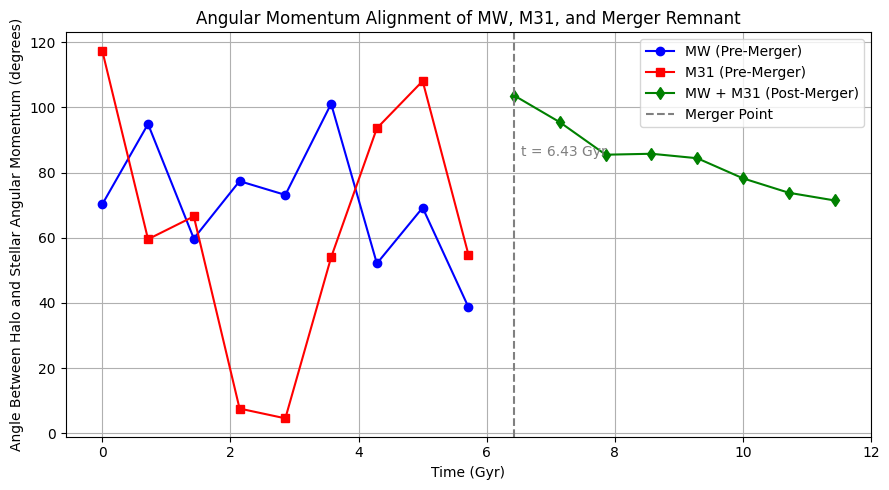

In [31]:
# Plot
plt.figure(figsize=(9, 5))

# Plot MW before merger
plt.plot(mw_times, mw_angles, marker ='o', color='blue', label='MW (Pre-Merger)')

# Plot M31 before merger
plt.plot(m31_times, m31_angles, marker ='s', color='red', label='M31 (Pre-Merger)')

# Plot merger
plt.plot(merger_times, merger_angles, marker ='d', color='green', label='MW + M31 (Post-Merger)')

# Mark the time merger occurs
if merger_times:
    merger_time = merger_times[0]
    plt.axvline(x=merger_time, color='gray', linestyle='--', label='Merger Point')

    # Label merger time above the vertical line
    plt.text(merger_time + 0.1, 85, f't = {merger_time:.2f} Gyr', color='gray')


# Labels and layout
plt.xlabel('Time (Gyr)')
plt.ylabel('Angle Between Halo and Stellar Angular Momentum (degrees)')
plt.title('Angular Momentum Alignment of MW, M31, and Merger Remnant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Angular_Momentum_MW_M31_Merger.png")
plt.show()

In [38]:
# 2nd Plot Code Outline

'''
Step 1: Initialize arrays to store angular momentum misalignment data
    a. Create time and angle arrays for MW (halo + disk)
    b. Create time and angle arrays for M31 (halo + disk)

Step 2: Compute reference angular momentum vectors from snapshot 0 using the previous angular_momentum function
    a. L0_halo and L0_disk for MW
    b. L0_halo and L0_disk for M31
    c. Apply radial cutoffs (63 kpc for halo, 15 kpc for disk) 

Step 3: Loop through each snapshot
    a. Read snapshot time and convert to Gyr
    b. Compute current halo and disk angular momentum vectors for MW and M31
    c. For each component:
        i. Compute angle between current vector and its snapshot 0 reference vector
        ii. Use dot product and arccos, clip to avoid rounding errors
        iii. Convert angle to degrees
    d. Append time and angles to corresponding arrays (from step 1)

Step 4: Plot results
    a. Create a single figure with 4 plots
    b. First 2 plots (MW): plot angle vs. time for MW disk and halo
    c. Second 2 plots (M31): plot angle vs. time for M31 disk and halo
    d. Add grid, labels, legend, and save the figure
'''

'\nStep 1: Initialize arrays to store angular momentum misalignment data\n    a. Create time and angle arrays for MW (halo + disk)\n    b. Create time and angle arrays for M31 (halo + disk)\n\nStep 2: Compute reference angular momentum vectors from snapshot 0 using the previous angular_momentum function\n    a. L0_halo and L0_disk for MW\n    b. L0_halo and L0_disk for M31\n    c. Apply radial cutoffs (63 kpc for halo, 15 kpc for disk) \n\nStep 3: Loop through each snapshot\n    a. Read snapshot time and convert to Gyr\n    b. Compute current halo and disk angular momentum vectors for MW and M31\n    c. For each component:\n        i. Compute angle between current vector and its snapshot 0 reference vector\n        ii. Use dot product and arccos, clip to avoid rounding errors\n        iii. Convert angle to degrees\n    d. Append time and angles to corresponding arrays (from step 1)\n\nStep 4: Plot results\n    a. Create a single figure with 4 plots\n    b. First 2 plots (MW): plot angl

In [33]:
# Empty arrays to store MW and M31 data
mw_times = []
mw_halo_angles = []
mw_disk_angles = []

m31_times = []
m31_halo_angles = []
m31_disk_angles = []

# Initial angular momentum vectors from snapshot 0 for reference
L0_halo_MW, _, _ = angular_momentum(f"{path_MW}\\MW_000.txt", 1, 63)
L0_disk_MW, _, _ = angular_momentum(f"{path_MW}\\MW_000.txt", 2, 15)

L0_halo_M31, _, _ = angular_momentum(f"{path_M31}\\M31_000.txt", 1, 63)
L0_disk_M31, _, _ = angular_momentum(f"{path_M31}\\M31_000.txt", 2, 15)

# Loop through snapshots
for snap in np.arange(0, 801, 50):
    fname_MW = f"{path_MW}\\MW_{snap:03}.txt"
    fname_M31 = f"{path_M31}\\M31_{snap:03}.txt"

    # Read time
    time, _, _ = Read(fname_MW)
    t_gyr = time.to(u.Gyr).value

    # --- MW ---
    # Calculate angular momentum
    L_halo_MW, _, _ = angular_momentum(fname_MW, 1, 63)
    L_disk_MW, _, _ = angular_momentum(fname_MW, 2, 15)

    # Calculate the angle relative to snapshot 0
    angle_halo_MW = np.degrees(np.arccos(np.clip(np.dot(L0_halo_MW, L_halo_MW) / 
                        (np.linalg.norm(L0_halo_MW) * np.linalg.norm(L_halo_MW)), -1, 1)))

    angle_disk_MW = np.degrees(np.arccos(np.clip(np.dot(L0_disk_MW, L_disk_MW) / 
                        (np.linalg.norm(L0_disk_MW) * np.linalg.norm(L_disk_MW)), -1, 1)))

    # Save MW times and aligments
    mw_times.append(t_gyr)
    mw_halo_angles.append(angle_halo_MW)
    mw_disk_angles.append(angle_disk_MW)

    # --- M31 ---
    # Calculate angular momentum
    L_halo_M31, _, _ = angular_momentum(fname_M31, 1, 63)
    L_disk_M31, _, _ = angular_momentum(fname_M31, 2, 15)

    # Calculate the angle relative to snapshot 0
    angle_halo_M31 = np.degrees(np.arccos(np.clip(np.dot(L0_halo_M31, L_halo_M31) / 
                        (np.linalg.norm(L0_halo_M31) * np.linalg.norm(L_halo_M31)), -1, 1)))

    angle_disk_M31 = np.degrees(np.arccos(np.clip(np.dot(L0_disk_M31, L_disk_M31) / 
                        (np.linalg.norm(L0_disk_M31) * np.linalg.norm(L_disk_M31)), -1, 1)))

    # Save M31 times and aligments
    m31_times.append(t_gyr)
    m31_halo_angles.append(angle_halo_M31)
    m31_disk_angles.append(angle_disk_M31)

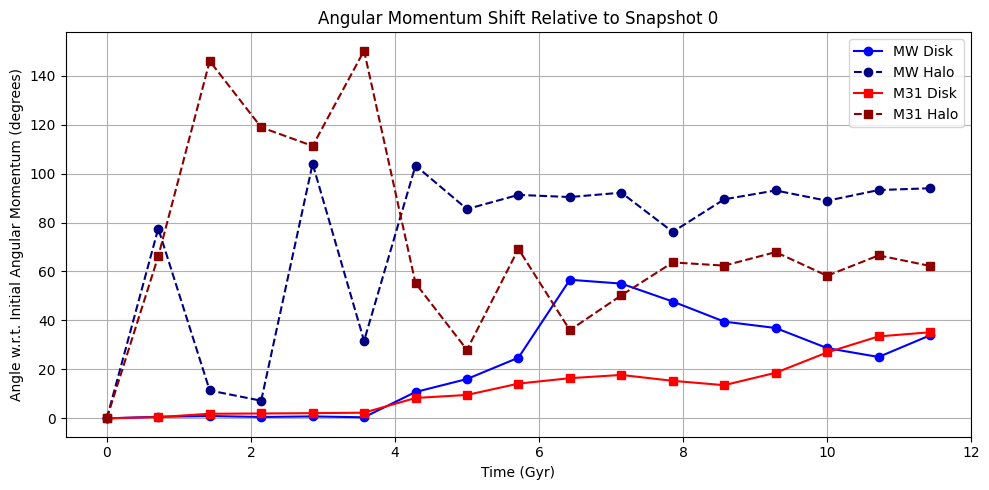

In [37]:
# Plot the angular momentum alignment over time relative to the present day (snapshot 0)
plt.figure(figsize=(10, 5))

# MW
plt.plot(mw_times, mw_disk_angles, label='MW Disk', color='blue', marker='o')
plt.plot(mw_times, mw_halo_angles, label='MW Halo', color='navy', linestyle='--', marker='o')

# M31
plt.plot(m31_times, m31_disk_angles, label='M31 Disk', color='red', marker='s')
plt.plot(m31_times, m31_halo_angles, label='M31 Halo', color='darkred', linestyle='--', marker='s')

# Labels and layouts
plt.xlabel('Time (Gyr)')
plt.ylabel('Angle w.r.t. Initial Angular Momentum (degrees)')
plt.title('Angular Momentum Shift Relative to Snapshot 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Angular_Momentum_Relative_To_Initial.png")
plt.show()